In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#use digits classification dataset from sklearn
from sklearn.datasets import load_breast_cancer


#data saved to object of class Bunch (subclass of dict)
bc = load_breast_cancer()

In [2]:
#dataset has 569 rows/samples and 30 columns/fts
bc.data.shape

(569, 30)

In [3]:
bc.target.shape

(569,)

In [1]:
print(bc.DESCR)

NameError: name 'bc' is not defined

In [5]:
#split data for training and testing
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, random_state = 5, test_size = 0.3)
#random state sets a random seed so we can replicate result by specifying seed

In [6]:
#train RF model

from sklearn.ensemble import RandomForestClassifier

#create RFC
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=12)

#train classifier
rf_classifier.fit(X_train, y_train)

#make predictions on test set
y_predicted = rf_classifier.predict(X_test)

In [7]:
#print testing accuracy of model
print("accuracy", f'{rf_classifier.score(X_test, y_test) :.2%}')

accuracy 97.08%


In [8]:
#a more nuanced way to check classification estimator's performance is via a confusion matrix
#it shows the correct and incorrect predicted values for each class

from sklearn.metrics import confusion_matrix
import pandas as pd

confusion = confusion_matrix(y_test, y_predicted)

#create dataframe for confusion matrix
confusion_df = pd.DataFrame(confusion, index=bc.target_names, columns=bc.target_names)
print(confusion_df)

#row=true class
#column=predicted class

           malignant  benign
malignant         58       3
benign             2     108


In [9]:
#sklearn also gives classification report

from sklearn.metrics import classification_report

report = classification_report(y_test, y_predicted, target_names=bc.target_names)
print(report)

#shows perofrmance metrics for each class
#'supprt' is # of testing samples in each class


              precision    recall  f1-score   support

   malignant       0.97      0.95      0.96        61
      benign       0.97      0.98      0.98       110

    accuracy                           0.97       171
   macro avg       0.97      0.97      0.97       171
weighted avg       0.97      0.97      0.97       171



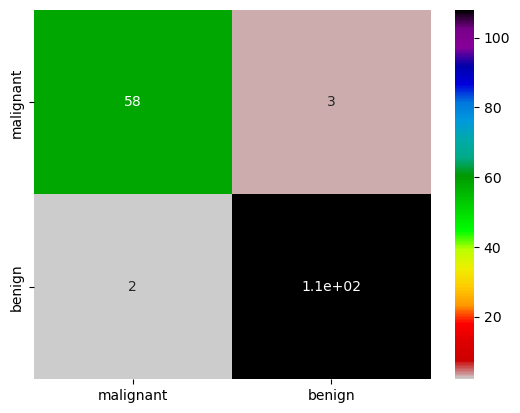

In [10]:
#use heatmap to visualize confusion matrix (which digit is most difficult to predict and which is likely to be wrongly predicted)

import seaborn as sns

axes = sns.heatmap(confusion_df, annot=True, cmap="nipy_spectral_r")


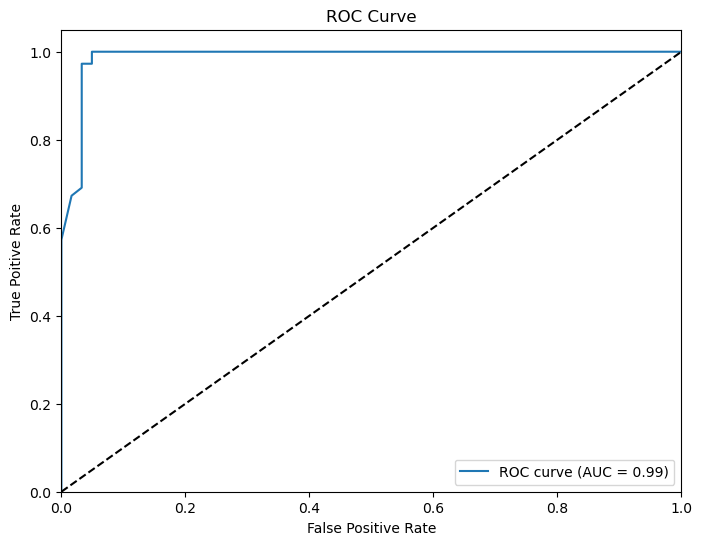

In [11]:
from sklearn.metrics import roc_curve, roc_auc_score

#predict probabilities for test data
probs = rf_classifier.predict_proba(X_test)[:, 1]

#calc FP and TP rates and thresholds
fpr, tpr, thresholds = roc_curve(y_test, probs)

#calc AUC
auc = roc_auc_score(y_test, probs)

#plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Poitive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [12]:
#get ft importances
importances = rf_classifier.feature_importances_

#Sort indices of ft importances in descending order
indices = np.argsort(importances)[::-1]

#print ft ranking
print('Feature Ranking:')

for f in range(bc.data.shape[1]):
    print("{}. Feature {} ({:.4f}): {}".format(f + 1, indices[f],
                                              importances[indices[f]], bc.feature_names[indices[f]]))


Feature Ranking:
1. Feature 27 (0.1679): worst concave points
2. Feature 20 (0.1277): worst radius
3. Feature 7 (0.1192): mean concave points
4. Feature 22 (0.1139): worst perimeter
5. Feature 23 (0.0874): worst area
6. Feature 26 (0.0474): worst concavity
7. Feature 6 (0.0454): mean concavity
8. Feature 3 (0.0401): mean area
9. Feature 13 (0.0371): area error
10. Feature 0 (0.0269): mean radius
11. Feature 12 (0.0182): perimeter error
12. Feature 1 (0.0176): mean texture
13. Feature 2 (0.0166): mean perimeter
14. Feature 24 (0.0132): worst smoothness
15. Feature 5 (0.0130): mean compactness
16. Feature 21 (0.0118): worst texture
17. Feature 29 (0.0111): worst fractal dimension
18. Feature 4 (0.0107): mean smoothness
19. Feature 25 (0.0103): worst compactness
20. Feature 10 (0.0100): radius error
21. Feature 16 (0.0084): concavity error
22. Feature 28 (0.0069): worst symmetry
23. Feature 17 (0.0064): concave points error
24. Feature 15 (0.0059): compactness error
25. Feature 19 (0.0053

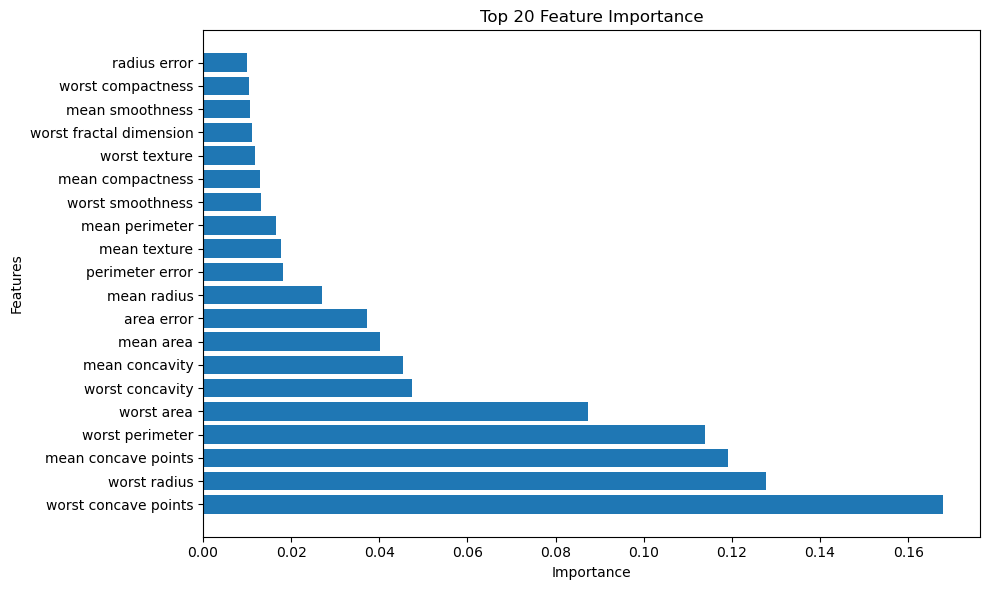

In [13]:
#sort indices of ft importances in descending order
indices = sorted (range(len(importances)), key=lambda k: importances[k], reverse=True)

#plot top x ft importances
top_features = 20
plt.figure(figsize=(10, 6))
plt.title("Top {} Feature Importance".format(top_features))
plt.barh(range(top_features), importances[indices][:top_features], align="center")
plt.yticks(range(top_features), bc.feature_names[indices][:top_features])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

In [14]:
#k-fold cross validation

from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, random_state=12, shuffle=True)

#n_splits specifies # of folds
#random state seeds random number generator for reproducibility
#shuffle decides is data is gonna be randomized by shuffling before splitting into folds
#helpful when samples in original data are ordered

In [15]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(estimator=rf_classifier, X=bc.data, y=bc.target, cv=kfold)

scores
#10 values is testing accuracy in each fold

array([0.94736842, 0.9122807 , 0.9122807 , 0.96491228, 0.98245614,
       1.        , 1.        , 1.        , 0.96491228, 0.96428571])

In [16]:
print(f"CV accuracy mean: {scores.mean():.2%}")
print(f"CV accuracy std: {scores.std():.2%}")

CV accuracy mean: 96.48%
CV accuracy std: 3.14%


In [17]:
#perform hyperparameter tuning on RF
from sklearn.model_selection import KFold, GridSearchCV

#define parameter grid for hyperparameter tuning
param_grid = {
    "n_estimators": [50,100,200],
    "max_depth": [None, 5, 10],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

#create k-fold cross validition object
kf = KFold(n_splits=10, shuffle=True, random_state=12)

#create GridSearchCV object for hyperparameter tuning
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=kf)

#hyperparameter tuning
grid_search.fit(bc.data, bc.target)

#get best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

#print
print("Best Parameters: ", best_params)
print("Best Score: {:.2f}%". format(best_score * 100))

Best Parameters:  {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Score: 96.66%


In [19]:
#run multiple estimators/models and find best one

from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

#loop iterates through items in estimators dictionary and for each key-valeu pair, it unpacks key into estimator_name 
#and value into estimator_object

estimators = {
    "KNN":KNeighborsClassifier(n_neighbors=3),
    "SVC": SVC(kernel='rbf', gamma='scale'),
    "GaussianNB": GaussianNB(),
    "RandomForest": RandomForestClassifier(max_depth=None, min_samples_leaf=1,
                                          min_samples_split=2, n_estimators=50, random_state=12),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=12)}

#exec models
#loop iterates
#unpacks key into estimator_name and val into ...
for estimator_name, estimator_object in estimators.items():
    kfold = KFold(n_splits=10, random_state=42, shuffle=True)
    scores = cross_val_score(estimator=estimator_object, X=bc.data, y=bc.target, cv=kfold)
    print(f'{estimator_name:>25}:' + f'mean accuracy= {scores.mean():.2%}; ' + f'std= {scores.std():.2%}')

                      KNN:mean accuracy= 92.78%; std= 4.30%
                      SVC:mean accuracy= 91.73%; std= 4.39%
               GaussianNB:mean accuracy= 93.84%; std= 3.19%
             RandomForest:mean accuracy= 95.61%; std= 1.17%
                      MLP:mean accuracy= 93.84%; std= 4.33%
